# Growth rate effect

In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import scipy as sp
from pylab import *
from networkx.drawing.nx_pydot import graphviz_layout
from networkx.algorithms import bipartite
import random as rd
from collections import Counter
import pylab 
import scipy.stats as stats
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.signal import savgol_filter


warnings.filterwarnings('ignore')

%matplotlib inline


# Model

In [2]:
#Function for drawing radial graphs in NetworkX library
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [3]:
#Counting the number of clusters and composition of cluster (cells per cluster)
def module_counter():
    global g
    cluster_counter=0
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==0):
            cluster_counter=cluster_counter+1
            for n in g.nodes():
                if(n.endswith(e[1][1:])):
                    g.nodes[n]['clust']=str(cluster_counter)

In [4]:
#Calculation of Kullback-Leibler Divergence between the experimental and model derived distribution
def KL(a, b):
    a = np.asarray(a, dtype=np.float)
    b = np.asarray(b, dtype=np.float)
    return np.sum(np.where(a != 0, a * np.log(a / b), 0))

In [5]:
#Count the distribution of number of cells per cluster
def count_freq(g):
    clust_information=[]
    for n in g.nodes():
        clust_information.append(g.nodes[n]['clust'])
    a=Counter(clust_information)
    freq=list(a.values())
    return freq

In [6]:
def graph_snap(t,sim_time):
    for n in g.nodes():
        g.nodes[n]['snap_time']=int(str(n)[1])
    for e in g.edges():
        if(g.edges[e[0],e[1]]['break']==1):
            g.edges[e[0],e[1]]['snap_time']=int(e[1][1])-1
        else:
            g.edges[e[0],e[1]]['snap_time']=sim_time

In [7]:

def break_cluster(t,max_node):
    global g
    cluster_counter=0
    degree_list=[]
    
    for e in g.edges():
        if(t>=g.edges[e[0],e[1]]['t_break'] and (g.edges[e[0],e[1]]['break']!=0)):
            g.edges[e[0],e[1]]['break']=0


    node_list=[node for node in g.nodes()]
    for node in node_list:
        edges_temp=g.edges(node)
        break_list=[g.edges[ed[0],ed[1]]['break'] for ed in edges_temp]
        degree_list.append(sum(break_list))
    max_nodes = [node_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    max_degrees = [degree_list[i] for i, x in enumerate(degree_list) if x == max(degree_list)]
    
    for i,node in enumerate(max_nodes):
        if(max_degrees[i]>=max_node):
            edges=[edge for edge in g.edges(node) if g.edges[edge[0],edge[1]]['break']!=0]
            edge_bt=[g.edges[e[0],e[1]]['t_break'] for e in edges]
            for k,bt in enumerate(edge_bt): 
                if(np.round(bt,0)>=t):
                    edge_tbb=edges[k]
                    g.edges[edge_tbb[0],edge_tbb[1]]['break']=0    

        

In [8]:
def grow(t,mbt):
    global g
    nextg=g.copy()
    for n in g.nodes():
        new_node='Y'+str(t)+'_'+str(n)[1:] #Naming daughter cells to track lineage information
        nextg.add_edge(str(n),new_node) #Growth
        nextg.nodes[new_node]['clust']=nextg.nodes[str(n)]['clust'] #Inherit the cluster information
        nextg.edges[str(n),new_node]['break']=1
        nextg.edges[str(n),new_node]['t_break']=t+np.random.exponential(scale=mbt)
    g=nextg



In [9]:
def init_system():
    global g
    g=nx.Graph() #Initialization 
    g.add_node('Y0') #Mother yeast cell 
    g.nodes['Y0']['clust']='0'
    nextg=g.copy()

In [10]:
def fit_fun(x,a,b):
    y=(a*x)/(b+x)
    return y

In [11]:
#Main function to call other functions associated with dissociation of the cluster, counting of cells per custer
def clust_form_and_break(sim_time,max_node,mbt,dt):
    global g
    
    init_system()
    
    for t in range(sim_time):
        if(int(t%dt)==0): 
            grow(t,mbt)
        break_cluster(t,max_node)
        graph_snap(t,sim_time)
    
    module_counter()
    
    return g

# For CTS1 delete with Kissing number 3

In [146]:
f=1
doubling_time=np.arange(2*f,8*f,1)/f
sim_time=doubling_time*10
l=25
# np.random.seed(50)

arr_tot_4=np.zeros(shape=(len(doubling_time),l))

for k in range(l):
    counts=pd.DataFrame()
    for d,s in zip(doubling_time,sim_time):
        g=clust_form_and_break(int(s),4,k*4,d)
        s=pd.Series(count_freq(g))
        s.name=str(d)    
        counts=pd.concat([counts,s],axis=1)
    arr_tot_4[:,k]=counts.mean(axis=0)

# For CTS1 delete with Kissing number 6

In [147]:
f=1
doubling_time=np.arange(2*f,8*f,1)/f
sim_time=doubling_time*10
l=25
# np.random.seed(50)

arr_tot_6=np.zeros(shape=(len(doubling_time),l))

for k in range(l):
    counts=pd.DataFrame()
    for d,s in zip(doubling_time,sim_time):
        g=clust_form_and_break(int(s),5,k*4,d)
        s=pd.Series(count_freq(g))
        s.name=str(d)    
        counts=pd.concat([counts,s],axis=1)
    arr_tot_6[:,k]=counts.mean(axis=0)

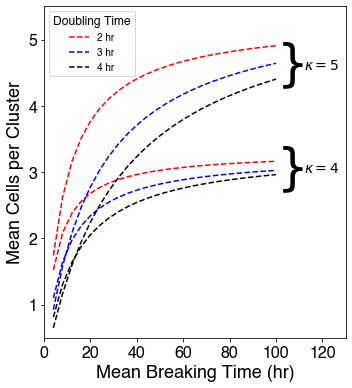

In [161]:
p=2
w=10
s=20
plt.rc('font',family='helvetica')
plt.figure(figsize=(5,5.5))

#Kissing Number 4
# plt.scatter(np.arange(1,26)*4,savgol_filter(arr_tot_4[0],w,p),s=s,color='red',marker='s')
# plt.scatter(np.arange(1,26)*4,savgol_filter(arr_tot_4[2],w,p),s=s,color='blue',marker='s')
# plt.scatter(np.arange(1,26)*4,savgol_filter(arr_tot_4[4],w,p),s=s,color='black',marker='s')


popt,pcov=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot_4[0,:],method='trf')
plt.plot(np.arange(1,26)*4,fit_fun(np.arange(1,26)*4,*popt),linestyle='--',color='red')

popt,pcov=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot_4[2,:],method='trf')
plt.plot(np.arange(1,26)*4,fit_fun(np.arange(1,26)*4,*popt),linestyle='--',color='blue')

popt,pcov=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot_4[4,:],method='trf')
plt.plot(np.arange(1,26)*4,fit_fun(np.arange(1,26)*4,*popt),linestyle='--',color='black')

#Kissing Number 6
# plt.scatter(np.arange(1,26)*4,savgol_filter(arr_tot_6[0],w,p),s=s,color='red')
# plt.scatter(np.arange(1,26)*4,savgol_filter(arr_tot_6[2],w,p),s=s,color='blue')
# plt.scatter(np.arange(1,26)*4,savgol_filter(arr_tot_6[4],w,p),s=s,color='black')


popt,pcov=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot_6[0,:],method='trf')
plt.plot(np.arange(1,26)*4,fit_fun(np.arange(1,26)*4,*popt),linestyle='--',color='red')

popt,pcov=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot_6[2,:],method='trf')
plt.plot(np.arange(1,26)*4,fit_fun(np.arange(1,26)*4,*popt),linestyle='--',color='blue')

popt,pcov=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot_6[4,:],method='trf')
plt.plot(np.arange(1,26)*4,fit_fun(np.arange(1,26)*4,*popt),linestyle='--',color='black')

plt.legend(['2 hr','3 hr','4 hr'],title='Doubling Time',loc='upper left',fontsize=10,title_fontsize=12)


plt.annotate(r'$\}$',xy=(100,2.83),fontsize=50)
plt.annotate(r'$\}$',xy=(100,4.4),fontsize=50)

plt.annotate(r'$\kappa=4$',xy=(112,3),fontsize=14)
plt.annotate(r'$\kappa=5$',xy=(112,4.55),fontsize=14)

plt.ylim(0.5,5.5)
plt.xlim(0,130)
plt.xlabel(r'Mean Breaking Time (hr)',fontsize=18)
plt.ylabel('Mean Cells per Cluster',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/sigmoid_func_vmax_km_curve.jpg',dpi=600)

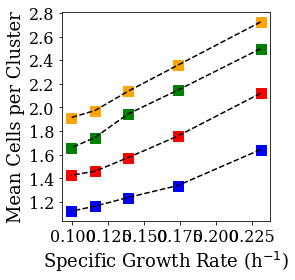

In [17]:
p=1
w=2
ind=[1,2,3,4,5]
doubling_time=np.arange(2*f,8*f,1)/f
doubling_time=0.693/doubling_time

plt.rc('font',family='serif')
plt.figure(figsize=(4,4))

color=['blue','red','green','orange']

for i in [1,2,3,4]:
    popt,pcov=sp.optimize.curve_fit(fit_fun,doubling_time[ind],arr_tot[ind,i],method='dogbox')
#     plt.plot(doubling_time[ind],fit_fun(doubling_time[ind],*popt),color='k',linestyle='--')
    plt.scatter(doubling_time[ind],savgol_filter(arr_tot[ind,i],w,p),s=100,marker='s',color=color[i-1])
    plt.plot(doubling_time[ind],savgol_filter(arr_tot[ind,i],w,p),color='k',linestyle='--')
# plt.legend(['MBT:4','MBT:8','MBT:12'])
plt.xlabel(r'Specific Growth Rate (h$^{-1}$)',fontsize=18)
plt.ylabel('Mean Cells per Cluster',fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
# plt.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/sigmoid_func_vmax_km_curve.jpg',dpi=600)

In [14]:
popt1,_=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot[0,:],method='trf')
popt2,_=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot[1,:],method='trf')
popt3,_=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot[2,:],method='trf')
popt4,_=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot[3,:],method='trf')
popt5,_=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot[4,:],method='trf')
popt6,_=sp.optimize.curve_fit(fit_fun,np.arange(1,26)*4,arr_tot[5,:],method='trf')

In [15]:
vm=[]
k=[]
for vmax,km in [popt1,popt2,popt3,popt4,popt5,popt6]:
   vm.append(vmax)
   k.append(km)

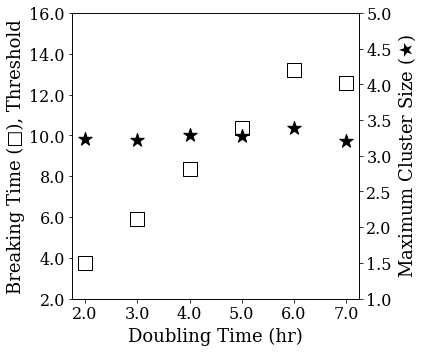

In [331]:
doubling_time=np.arange(2*f,8*f,1)/f
plt.rc('font',family='serif')
fig,ax1=plt.subplots(nrows=1,ncols=1,figsize=(6,5))
ax2=ax1.twinx()
ax1.scatter(doubling_time,k,marker='s',color='white',edgecolors='black',linewidth=1,s=200)
ax2.scatter(doubling_time,vm,marker='*',color='k',s=200)
ax1.set_ylim(2,16)
ax2.set_ylim(1,5)
ax1.set_xlabel('Doubling Time (hr)',fontsize=18)
ax1.set_ylabel(r'Breaking Time (□), Threshold',fontsize=18)
ax2.set_ylabel(r'Maximum Cluster Size ($\bigstar$)',fontsize=18)
ax1.set_xticklabels(ax1.get_xticks(),fontsize=16)
ax1.set_yticklabels(ax1.get_yticks(),fontsize=16)
ax2.set_yticklabels(ax2.get_yticks(),fontsize=16)
fig.tight_layout()
fig.savefig('/Users/piyushnanda/Documents/PhD_MurrayLab/EMC/Figures/Final/sigmoid_func_vmax_km.jpg',dpi=600)